# Load embedding model from classification model's `state_dict`

In [1]:
%matplotlib inline

import sys

sys.path.append("..")

First, we load the checkpoint generated during training:

In [2]:
import os, pickle, sys, torch

from settings import ROOT_DIR

resume = '19-05-23T08-24'
start_epoch = 13

checkpoint_directory = os.path.join(ROOT_DIR, 'static', 'checkpoints', 'cnn_sk', resume)

net = torch.load(os.path.join(checkpoint_directory, '_net_%s.pth' % start_epoch))
net

C:\Anaconda\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'src.models.convolutional.classification.ClassificationConvolutionalNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


ClassificationConvolutionalNetwork(
  (convolution_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (convolution_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (convolution_3): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fully_connected_1): Linear(in_features=16820, out_features=15000, bias=True)
  (fully_connected_2): Linear(in_features=15000, out_features=1200, bias=True)
  (fully_connected_3): Linear(in_features=1200, out_features=125, bias=True)
)

Now we retrieve only the network's `state_dict`, as we are only interested in model weights: 

In [3]:
state_dict = net.state_dict()

Now we have to remove the keys in the state dict that correspond to the removed classification layers (the outermost ones)

In [4]:
del state_dict['fully_connected_3.weight']
del state_dict['fully_connected_3.bias']
state_dict.keys()

odict_keys(['convolution_1.weight', 'convolution_1.bias', 'convolution_2.weight', 'convolution_2.bias', 'convolution_3.weight', 'convolution_3.bias', 'fully_connected_1.weight', 'fully_connected_1.bias', 'fully_connected_2.weight', 'fully_connected_2.bias'])

Finally, we instance the new model (the embedding network) with the state_dict

In [5]:
from src.models.convolutional.classification import ConvolutionalNetwork

net = ConvolutionalNetwork()
net.load_state_dict(state_dict, strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

No incompatible keys found, so the weights were correctly loaded.

# Load image dataset

In [6]:
# Load the Dataset class

from settings import DATA_SOURCES
from src.datasets.sketchy import Sketchy

dataset = Sketchy(DATA_SOURCES['sketchy']['sketches'])
len(dataset)

75481

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Number of workers for dataloader
workers = 8

# Batch size for dataloader
batch_size = 1

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

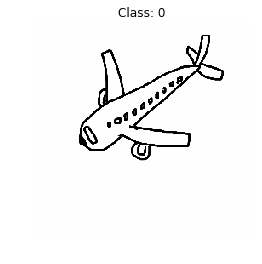

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot some training images
image = dataset[0]
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Class: %s" % image[1])
plt.imshow(np.transpose(vutils.make_grid(image[0].to(device), padding=2, normalize=True).cpu(), (1,2,0)))

# Generate an embedding for every image in the dataset

In [9]:
# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

In [13]:
from tqdm import tqdm

for i, data in tqdm(enumerate(data_loader, 0)):
    # get the inputs
    inputs, _ = data

    inputs = inputs.to(device)

    # forward + save feature vectors
    torch.save(net(inputs), 'vectors/%s.pth' % i)

75481it [1:37:04, 13.60it/s]


In [14]:
from tqdm import tqdm

vectors = []

for i in tqdm(range(len(dataset))):
    vectors.append(torch.load('vectors/%s.pth' % i))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75481/75481 [00:17<00:00, 4290.90it/s]


In [15]:
import pickle

pickle.dump(vectors, open('sketchy_sketches_vectors.pickle', 'wb'))

In [9]:
import pickle

vectors = pickle.load(open('sketchy_sketches_vectors.pickle', 'rb'))

# Queries

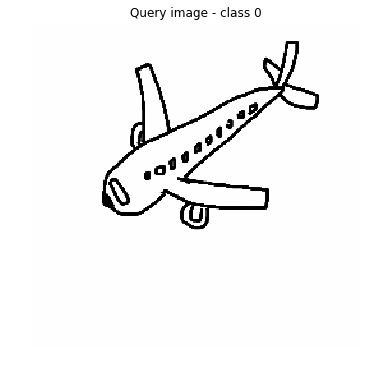

In [10]:
import numpy as np
import torchvision.utils as vutils

query = 0
image = dataset[query]
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Query image - class %s" % image[1])
plt.imshow(np.transpose(vutils.make_grid(image[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

KNN search duration: 0:04:13.544098
[20, 37, 86, 61, 57, 20, 85, 20, 7, 88, 28, 57, 60, 57, 86, 40]


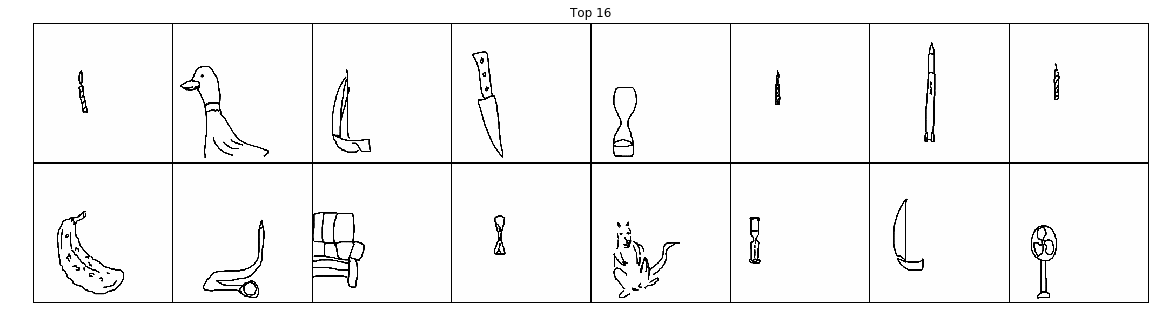

In [11]:
import time, torch

import numpy as np
import torchvision.utils as vutils

from datetime import datetime
from torch.nn.functional import cosine_similarity

k = 16

start = datetime.now()

results = [(i, dataset[i][1], cosine_similarity(vectors[query], vector)) for i, vector in enumerate(vectors)] # (id, class, similarity)
results = sorted(results, key=lambda tup: tup[2])

print('KNN search duration: %s' % (datetime.now() - start))

print([result[1] for result in results[0:k]])

top_k = torch.stack([dataset[i][0] for i, j, _ in results[0:k]])

plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Top %s" % k)
plt.imshow(np.transpose(vutils.make_grid(top_k.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Using sklearn KNN

In [32]:
torch.stack(vectors).squeeze().size()

torch.Size([75481, 1200])

In [35]:
import torchvision.utils as vutils

from datetime import datetime
from sklearn.neighbors import NearestNeighbors

k = 16

start = datetime.now()

print('KNN search duration: %s' % (datetime.now() - start))

with torch.no_grad():
    results  = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine').fit(torch.stack(vectors).squeeze())

distances, indices = results.kneighbors()

print([result[1] for result in results[0:k]])

top_k = torch.stack([dataset[i][0] for i, j, _ in results[0:k]])

plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Top %s" % k)
plt.imshow(np.transpose(vutils.make_grid(top_k.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

KNN search duration: 0:00:00


TypeError: 'NearestNeighbors' object is not subscriptable

In [36]:
results.kneighbors()

MemoryError: 